# Basic Exploratory Data Analysis

A starter notebook to begin characterizing the segmented hemorrhages in the [public dataset](https://www.mdpi.com/2306-5729/5/1/14) we are analyzing as a part of **Aim 1.1: Characterizing Real ICH**

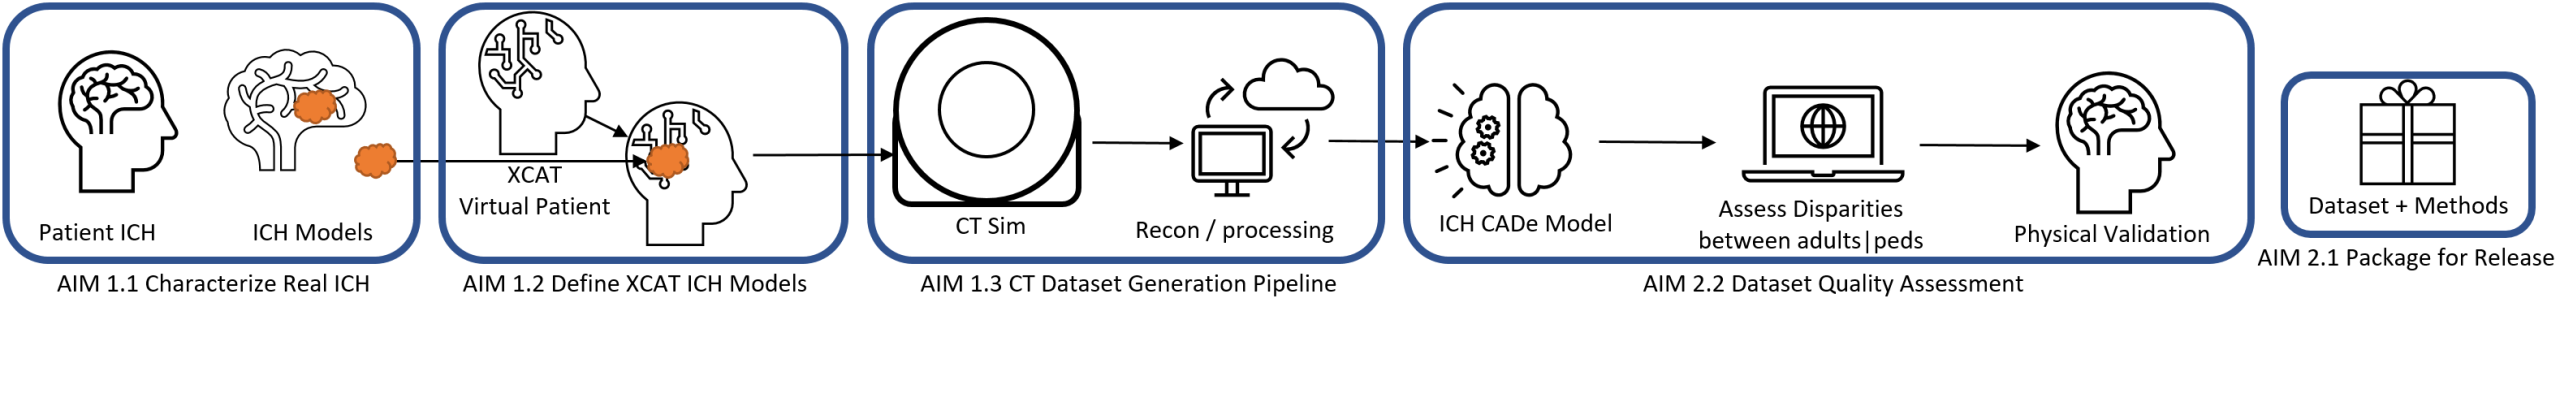

## Introduction 

Previously, [patient_demographics.ipynb](patient_demographics.ipynb) began characterizing the [patient metadata](/gpfs_projects/common_data/CT_intracranial_hemorrhage/patient_demographics.csv) of this dataset. *The same could be done to characterize the lesions themselves using [hemorrhage_diagnosis.csv](/gpfs_projects/common_data/CT_intracranial_hemorrhage/hemorrhage_diagnosis.csv).*

### Aim

The aim of this notebook is to now characterize the images and ground truth segmentation labels. Some basic characterizations of CT hemorrhage include (but are not limited to) - links to papers or implementations would also be helpful -:

**morphology**
- hemorrhage volume
- [circularity](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html) - scikit-image region props has other simple shape descriptors
- location in the brain (hemisphere, proximity to skull or other structures, etc..)

**contrast**
- [pixel intensity histograms](https://datacarpentry.org/image-processing/05-creating-histograms.html) in and around the segmentations
- [entropy](https://scikit-image.org/docs/stable/auto_examples/filters/plot_entropy.html)

**texture**
- pixel heteorogeneity within and around the segmentations

### Resources

- [CaPTK](https://www.med.upenn.edu/cbica/captk/): developed for characterizing cancer imaging phenotypes, but many of the quantitative radiomic tools are likely also applicable here too
- [pyradiomics](https://pyradiomics.readthedocs.io/en/latest/): for radiomic feature extraction
- [Mahotas](https://mahotas.readthedocs.io/en/latest/) Computer vision in python, has some useful features for texture characterization - like [Haralick features](https://mahotas.readthedocs.io/en/latest/features.html#haralick-features)
- [OpenCV](https://docs.opencv.org/4.x/d9/d97/tutorial_table_of_content_features2d.html): a collection of tutorials using OpenCV for feature extraction

In [1]:
!ls /gpfs_projects/common_data/CT_intracranial_hemorrhage

ct_ich.yml		  LICENSE.txt		    Patients_CT  SHA256SUMS.txt
hemorrhage_diagnosis.csv  patient_demographics.csv  README.txt	 split_data.py


In [2]:
!cat /gpfs_projects/common_data/CT_intracranial_hemorrhage/README.txt

By Murtadha Hssayeni, mhssayeni2017@fau.edu 8/13/2018

Dataset name: Computed Tomography Images for Intracranial Hemorrhage Detection and Segmentation
Authors: Murtadha D. Hssayeni, M.S., Muayad S. Croock, Ph.D., Aymen Al-Ani, Ph.D., Hassan Falah Al-khafaji, M.D. and Zakaria A. Yahya, M.D.


A retrospective study was designed to collect head CT scans of subjects with TBI and it was approved by the research and ethics board in the Iraqi ministry of health-Babil Office. CT scans were collected between February and August 2018 from Al Hilla Teaching Hospital-Iraq. Patients information were anonymized. A dataset of 82 CT scans was collected that included 36 scans for patients diagnosed with intracranial hemorrhage with the following types (Intraventricular, Intraparenchymal, Subarachnoid, Epidural and Subdural). Each CT scan for each patient includes about 30 slices with 5 mm slice-thickness. The mean and std of patients' age are 27.8 and 19.5, respectively. 46 of the patients are males an

## Looking at the images and filtering by the metadata

This brief section aims to familiarize us with the dataset by making it easier to look at the images in the different displays, overlay the hemorrhage segmentations if they exist, and compare against the provided patient-level and lesion-level metadata

In [3]:
!pip install -q -r requirements.txt

In [4]:
import pandas as pd
from pathlib import Path

base_dir = Path('/gpfs_projects/common_data/CT_intracranial_hemorrhage')
patients_df = pd.read_csv(base_dir / 'patient_demographics.csv', index_col=0)
patients_df.head()

,Age\n(years),Gender,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture (Yes/No),Condition on file,Note
Patient Number,,,,,,,,,,
49,35.000000,Male,NaN,1.0,NaN,1.0,NaN,1.0,Intracranial HGE+ Extradural HGE,NaN
50,0.583333,Female,NaN,1.0,NaN,NaN,NaN,1.0,Subdural HGE,NaN
51,5.000000,Male,NaN,1.0,NaN,NaN,1.0,1.0,Extadural HGE,NaN
52,8.000000,Male,NaN,NaN,NaN,1.0,NaN,1.0,Extadural HGE,NaN
53,44.000000,Male,NaN,1.0,NaN,1.0,NaN,1.0,Intracranial HGE+ Extradural HGE,NaN


We previously looked at this dataframe in more detail here: [patient_demographics.ipynb](patient_demographics.ipynb)

In [5]:
hemorrhages_df = pd.read_csv(base_dir / 'hemorrhage_diagnosis.csv')
hemorrhages_df.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0


Let's add columns for file locations to make accessing images easier like a database..

In [6]:
for display in ['brain', 'bone']:
    hemorrhages_df[f'{display} filename'] = base_dir / 'Patients_CT' / (hemorrhages_df['PatientNumber'].apply(lambda o: str(o).zfill(3)) + '/' + display + '/' + hemorrhages_df['SliceNumber'].astype(str) + '.jpg')
hemorrhages_df.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No,brain filename,bone filename
0,49,1,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
1,49,2,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
2,49,3,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
3,49,4,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
4,49,5,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...


In [7]:
hemorrhages_df['brain filename'].head()

0    /gpfs_projects/common_data/CT_intracranial_hem...
1    /gpfs_projects/common_data/CT_intracranial_hem...
2    /gpfs_projects/common_data/CT_intracranial_hem...
3    /gpfs_projects/common_data/CT_intracranial_hem...
4    /gpfs_projects/common_data/CT_intracranial_hem...
Name: brain filename, dtype: object

Now we can easily filter the dataframe and look at the images we want, say those with hemorrhage for example. Now, I interpret `No_Hemorrhage` to mean *no* hemorrhage, as in columns: `Intraventricular`, `Intraparenchymal`,	`Subarachnoid`, `Epidural`,	`Subdural` are all 0, so we can use this to filter to slices that *do* have hemorrhage by filter by the rows where this condition is False

In [8]:
hemorrhages_df[hemorrhages_df['No_Hemorrhage'] == False].head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No,brain filename,bone filename
13,49,14,0,0,0,1,0,0,1,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
14,49,15,0,0,0,1,0,0,1,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
15,49,16,0,0,0,1,0,0,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
16,49,17,0,0,0,1,0,0,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
19,49,20,0,0,0,1,0,0,1,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...


Let's also define a function to get the segmentation mask if it exists.

In [9]:
!ls /gpfs_projects/common_data/CT_intracranial_hemorrhage/Patients_CT/049/brain/

10.jpg		15.jpg		1.jpg		23_HGE_Seg.jpg	28.jpg	3.jpg
11.jpg		16_HGE_Seg.jpg	20_HGE_Seg.jpg	23.jpg		29.jpg	4.jpg
12.jpg		16.jpg		20.jpg		24.jpg		2.jpg	5.jpg
13.jpg		17_HGE_Seg.jpg	21_HGE_Seg.jpg	25.jpg		30.jpg	6.jpg
14_HGE_Seg.jpg	17.jpg		21.jpg		26.jpg		31.jpg	7.jpg
14.jpg		18.jpg		22_HGE_Seg.jpg	27_HGE_Seg.jpg	32.jpg	8.jpg
15_HGE_Seg.jpg	19.jpg		22.jpg		27.jpg		33.jpg	9.jpg


In [10]:
def get_hemorrhage_mask(filename):
    filename = Path(filename)
    mask_filename = filename.parent / (filename.stem + '_HGE_Seg.jpg')
    return mask_filename if mask_filename.exists() else None

In [11]:
get_hemorrhage_mask(hemorrhages_df[hemorrhages_df['No_Hemorrhage'] == False]['brain filename'].iloc[0]), get_hemorrhage_mask(hemorrhages_df[hemorrhages_df['No_Hemorrhage'] == True]['brain filename'].iloc[0])

(PosixPath('/gpfs_projects/common_data/CT_intracranial_hemorrhage/Patients_CT/049/brain/14_HGE_Seg.jpg'),
 None)

Note that if the mask *does not exist* it returns `None`

PatientNumber                                                      49
SliceNumber                                                        14
Intraventricular                                                    0
Intraparenchymal                                                    0
Subarachnoid                                                        0
Epidural                                                            1
Subdural                                                            0
No_Hemorrhage                                                       0
Fracture_Yes_No                                                     1
brain filename      /gpfs_projects/common_data/CT_intracranial_hem...
bone filename       /gpfs_projects/common_data/CT_intracranial_hem...
Name: 13, dtype: object
Age\n(years)                                      35.0
Gender                                            Male
Intraventricular                                   NaN
Intraparenchymal                         

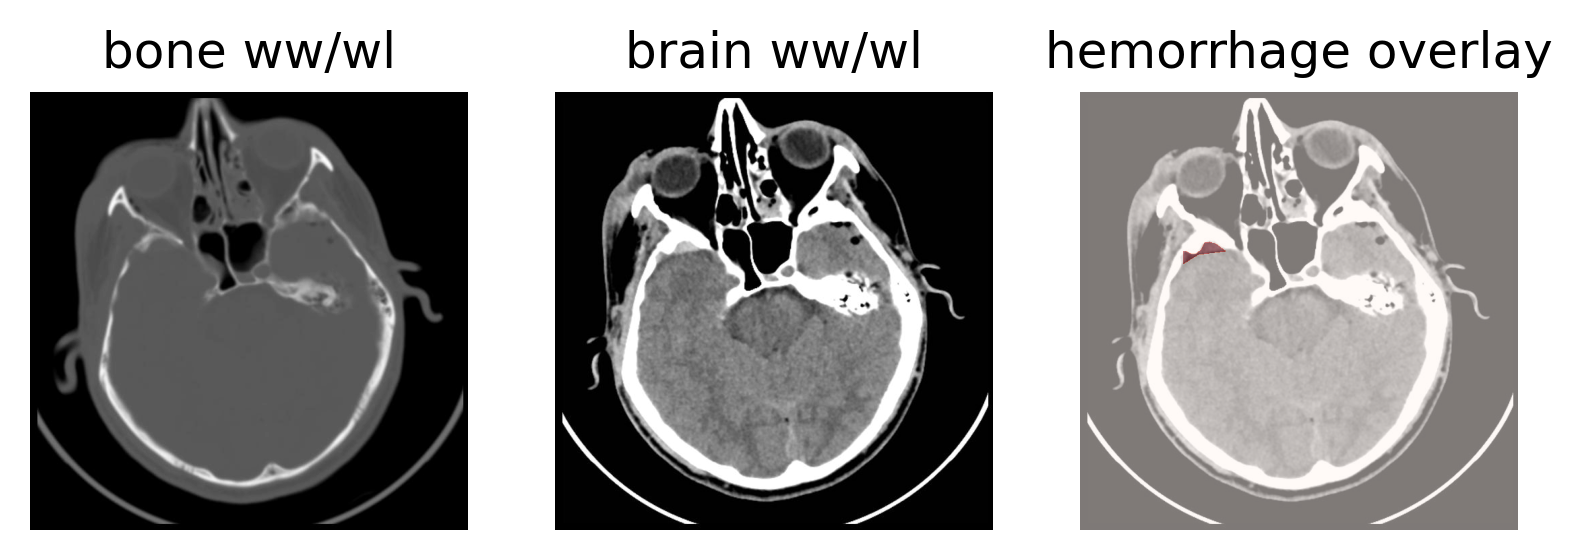

In [12]:
import matplotlib.pyplot as plt

def display_images(row, show_header_info=False):
    'requires a `row` from the `hemorrhages_df` dataframe and will print patient and lesion information while showing brain, bone, and lesion images side-by-side'
    if show_header_info:
        print(row)
        print(patients_df[patients_df.index == row.PatientNumber].iloc[0])
    brain_display_filename = row['brain filename']
    bone_display_filename = row['bone filename']
    hemorrhage_mask_filename = get_hemorrhage_mask(brain_display_filename)

    brain_img = plt.imread(brain_display_filename)
    bone_img = plt.imread(bone_display_filename)

    f, axs = plt.subplots(1,3, dpi=300)
    axs[0].axis('off')
    axs[0].imshow(bone_img, cmap='gray')
    axs[0].set_title('bone ww/wl')
    axs[1].axis('off')
    axs[1].imshow(brain_img, cmap='gray')
    axs[1].set_title('brain ww/wl')

    if hemorrhage_mask_filename:
        mask_img = plt.imread(hemorrhage_mask_filename)
        axs[2].axis('off')
        axs[2].imshow(brain_img, cmap='gray')
        axs[2].imshow(mask_img, cmap='Reds', alpha=0.5)
        axs[2].set_title('hemorrhage overlay')

row = hemorrhages_df[hemorrhages_df['No_Hemorrhage'] == False].iloc[0]
display_images(row, show_header_info=True)

In [13]:
from ipywidgets import interact, IntSlider, Checkbox

def display_images_widget(hemorrhage=True, patientnumber=49, image_index=0, show_header_info=False):
    'note that `image_index` does not necesarrily agree with slice number since `image_index` starts at the bottom of the scan if there is not hemorrhage or at the first segmentation slice if a segmentation is present'
    filtered_df = hemorrhages_df[(hemorrhages_df['No_Hemorrhage'] != hemorrhage) & (hemorrhages_df['PatientNumber']==patientnumber)]
    if image_index > len(filtered_df):
        print(f'image_index: {image_index} exceeds the available slices: {len(filtered_df)}, please select a smaller index to view')
    row = filtered_df.sort_values(by='SliceNumber').iloc[image_index]
    display_images(row, show_header_info)

max_slice_idx = max([len(hemorrhages_df[(hemorrhages_df.PatientNumber == n)]) for n in hemorrhages_df.PatientNumber.unique()])
    
interact(display_images_widget,
         hemorrhage=[True, False],
         patientnumber=patients_df.index.unique(),
         image_index=IntSlider(value=0, min=0, max=max_slice_idx),
         show_header_info=Checkbox(value=False, description='print header'))

interactive(children=(Dropdown(description='hemorrhage', options=(True, False), value=True), Dropdown(descript…

<function __main__.display_images_widget(hemorrhage=True, patientnumber=49, image_index=0, show_header_info=False)>

## Lesion Morphology
 
Here we can start to aggregate lesion morphology properties like shape, volume - both on the slice-level, and patient-level and plot against patient metadata like age or ICH type to start looking for trends...

As discussed in [Hillal 2022](https://insightsimaging.springeropen.com/articles/10.1186/s13244-022-01309-1), shape and density heterogeneity indicate the maturity of the hematoma (bleed):

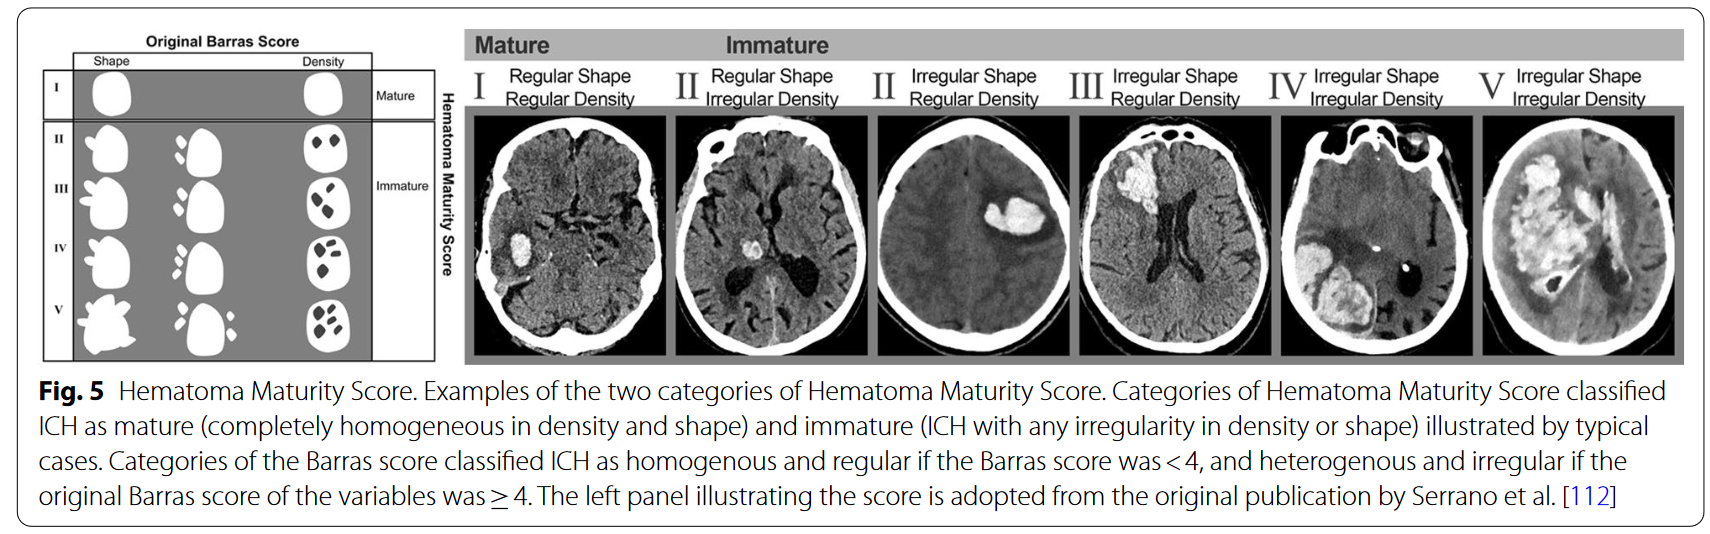

### Hemorrhage Volume

Let's start simple by summing the total hemorrhage per slice then aggregate that by patient. According to Hillal 2022 "**Hematoma volume** is considered the strongest predictor of 30-day mortality and functional outcome for ICH patients [9]"

In [14]:
patients = hemorrhages_df['PatientNumber'].unique()
patient = patients[0]

In [15]:
import numpy as np
lesion_mask = plt.imread(get_hemorrhage_mask(row['brain filename']))
np.unique(lesion_mask.ravel())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  23,  28, 219, 226,
       230, 231, 232, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255], dtype=uint8)

Due to blurring or jpg storage, even though there is a single class in this segmentation we need to binarize using a threshold ^ to only get 2 classes [0, 1] for no hemorrhage, hemorrhage respectively 

Text(0.5, 1.0, 'lesion volume: 467329 pixels')

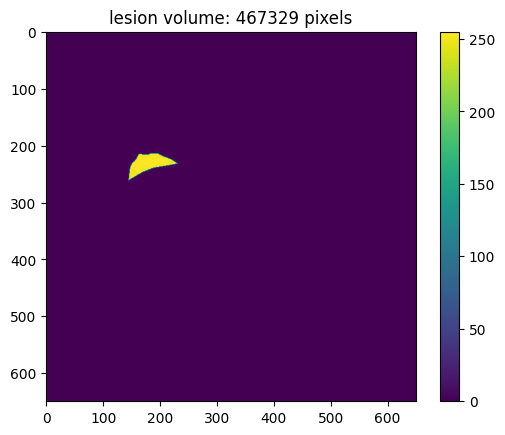

In [16]:
row = hemorrhages_df[hemorrhages_df['No_Hemorrhage']==False].iloc[1]
lesion_mask = plt.imread(get_hemorrhage_mask(row['brain filename']))
slice_vol = lesion_mask.sum()
plt.imshow(lesion_mask)
plt.colorbar()
plt.title(f'lesion volume: {slice_vol} pixels')

What threshold to pick?

Text(0, 0.5, 'pixel count')

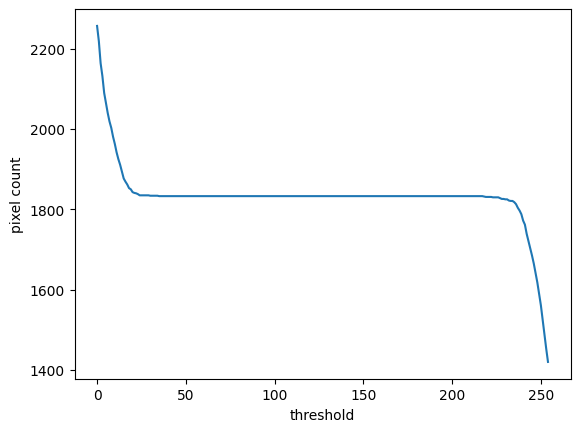

In [17]:
list_of_thresholds = list(range(255))
counts = [(lesion_mask > t).sum() for t in list_of_thresholds]
plt.plot(list_of_thresholds, counts)
plt.xlabel('threshold')
plt.ylabel('pixel count')

Based on the above any threshold between 50 and 200 is reasonable, so let's pick 100 since it's a round number

In [18]:
threshold = 100

Text(0.5, 1.0, 'lesion volume: 1833 pixels')

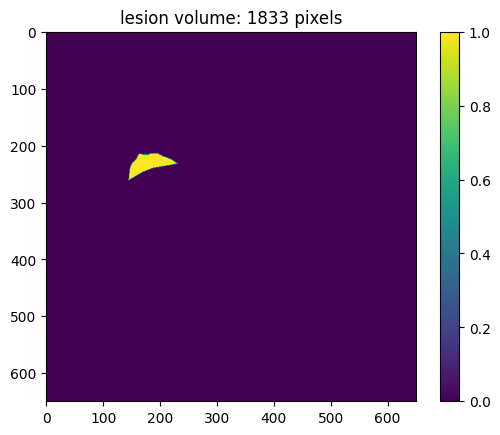

In [19]:
row = hemorrhages_df[hemorrhages_df['No_Hemorrhage']==False].iloc[1]
lesion_mask = plt.imread(get_hemorrhage_mask(row['brain filename'])) > threshold
slice_vol = lesion_mask.sum()
plt.imshow(lesion_mask)
plt.colorbar()
plt.title(f'lesion volume: {slice_vol} pixels')

Now write a quick function to measure the hemorrhage pixels for each row in the `hemorrhage dataframe`

In [20]:
def measure_slicewise_hemorrhage_volume(fname):
    threshold = 100
    lesion_mask_fname = get_hemorrhage_mask(fname)
    if lesion_mask_fname:
        lesion_mask = plt.imread(lesion_mask_fname) > threshold
        slice_vol = lesion_mask.sum()
    else:
        slice_vol = 0
    return slice_vol

In [21]:
hemorrhages_df['hemorrhage volume [pixels]'] = hemorrhages_df['brain filename'].apply(measure_slicewise_hemorrhage_volume)
hemorrhages_df.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No,brain filename,bone filename,hemorrhage volume [pixels]
0,49,1,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...,0
1,49,2,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...,0
2,49,3,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...,0
3,49,4,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...,0
4,49,5,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...,0


According to the dataset paper [Hssayeni et al 2020](https://www.mdpi.com/2306-5729/5/1/14) scans had an inplace resolution of 0.33 mm and 5 mm slice thickness, we can use this to convert from pixel volume to mm^3 and mL volume

In [22]:
slice_thickness_mm = 5
pixel_size_mm = 0.33
mm3_per_ml = 1000
hemorrhages_df['hemorrhage volume [mL]'] = hemorrhages_df['hemorrhage volume [pixels]'].apply(lambda o: o*slice_thickness_mm*pixel_size_mm**2/mm3_per_ml)

Now summarize by patient

In [23]:
hemorrhage_volume_summary = hemorrhages_df[['PatientNumber', 'hemorrhage volume [mL]']].groupby(['PatientNumber']).sum()
hemorrhage_volume_summary.head()

,hemorrhage volume [mL]
PatientNumber,
49,5.339367
50,6.133793
51,33.496551
52,5.829962
53,5.898024


Now add it to the patient dataframe

In [24]:
patients_df['hemorrhage volume [mL]'] = hemorrhage_volume_summary['hemorrhage volume [mL]']
patients_df.head()

,Age\n(years),Gender,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture (Yes/No),Condition on file,Note,hemorrhage volume [mL]
Patient Number,,,,,,,,,,,
49,35.000000,Male,NaN,1.0,NaN,1.0,NaN,1.0,Intracranial HGE+ Extradural HGE,NaN,5.339367
50,0.583333,Female,NaN,1.0,NaN,NaN,NaN,1.0,Subdural HGE,NaN,6.133793
51,5.000000,Male,NaN,1.0,NaN,NaN,1.0,1.0,Extadural HGE,NaN,33.496551
52,8.000000,Male,NaN,NaN,NaN,1.0,NaN,1.0,Extadural HGE,NaN,5.829962
53,44.000000,Male,NaN,1.0,NaN,1.0,NaN,1.0,Intracranial HGE+ Extradural HGE,NaN,5.898024


<Axes: xlabel='Age\n(years)', ylabel='hemorrhage volume [mL]'>

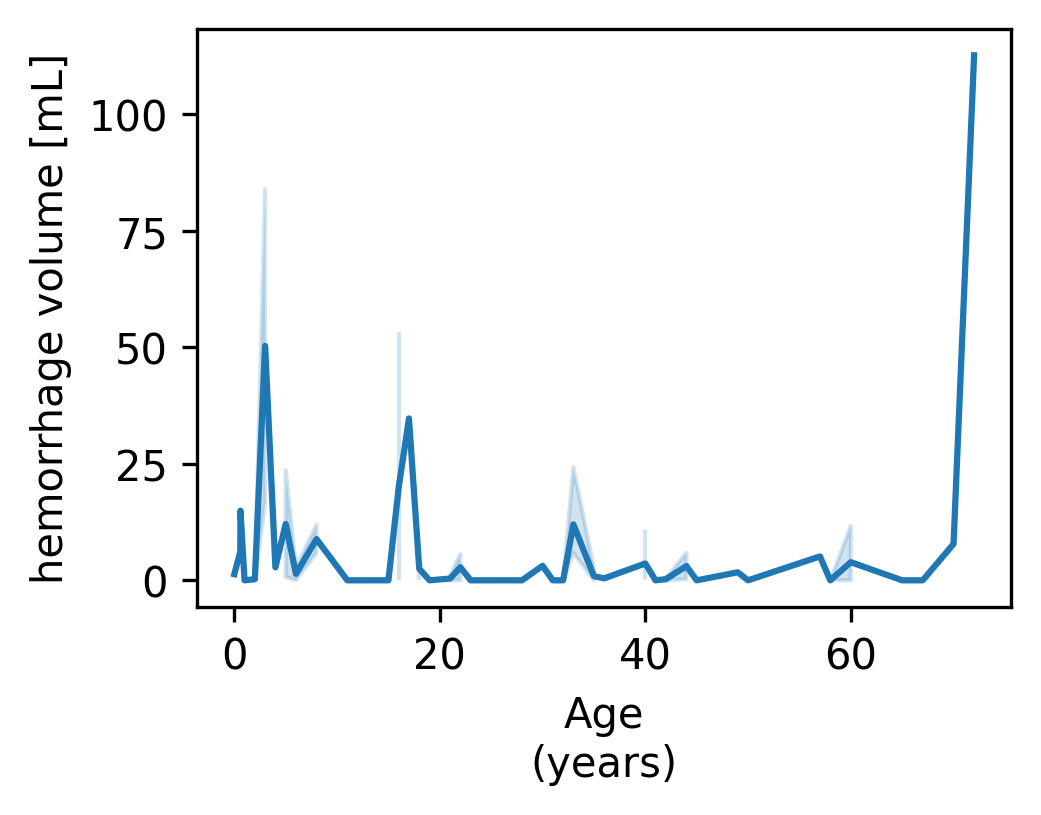

In [25]:
import seaborn as sns
f, ax = plt.subplots(figsize=(3.5, 2.5), dpi=300)
sns.lineplot(ax=ax, data=patients_df, x='Age\n(years)', y='hemorrhage volume [mL]')

Need to consider the young patients have smaller heads (this is true but pediatric head size is the first to grow and then level off, while the rest of the body lags behind [WHO head growth curves](https://cdn.who.int/media/docs/default-source/child-growth/child-growth-standards/indicators/head-circumference-for-age/cht_hcfa_boys_z_0_5.pdf)) Normalize volume by brain volume
identify task
-



This bimodal distribution of **hemorrhage volume** is similar to the distribution of patients included in the dataset shown in [patient_demographics.ipynb](patient_demographics.ipynb), however what's different is that by **volume** there is much more in the older/oldest patients in the study (note each data point above is 1 patient).

This starts to get to our first question of Aim 1.1, which is **how hemorrhage characteristics vary by age**, while the answer is likely known in the literature, this is helpful by quantifying in our dataset such that we can hope to reproduce this distribution for this hemorrhage characteristic (as one part of the several characteristics we aim to reproduce).

In [26]:
patients_over_60yrs = len(patients_df[patients_df['Age\n(years)']>60])
patients_over_60yrs_w_hemorrhage = len(patients_df[(patients_df['Age\n(years)']>60) & (patients_df['hemorrhage volume [mL]']>0)])
print(f'Number of patients in dataset over 60 yrs                : {patients_over_60yrs}')
print(f'Number of patients in dataset over 60 yrs with hemorrhage: {patients_over_60yrs_w_hemorrhage}')

Number of patients in dataset over 60 yrs                : 4
Number of patients in dataset over 60 yrs with hemorrhage: 2


<Axes: xlabel='Patient Number', ylabel='hemorrhage volume [mL]'>

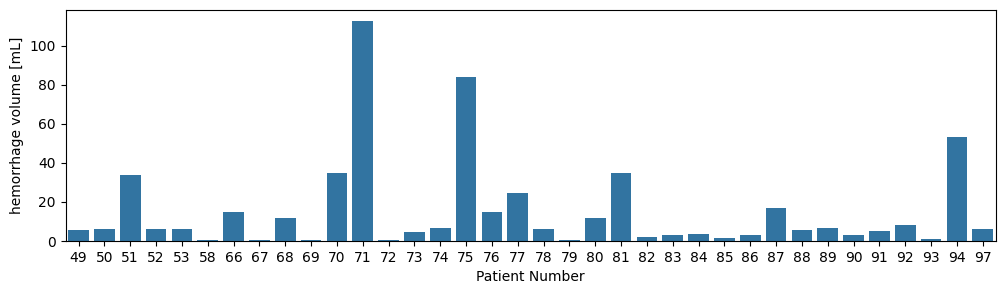

In [27]:
f, ax = plt.subplots(figsize=(12, 3))
sns.barplot(ax=ax, data=patients_df[patients_df['hemorrhage volume [mL]']>0], x='Patient Number', y='hemorrhage volume [mL]')

Sorted by hemorrhage volume

Text(0.5, 1.0, 'Ordered by hemorrhage volume')

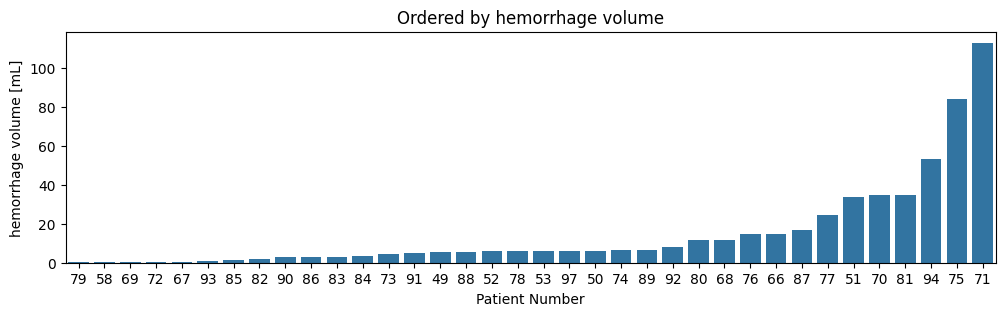

In [28]:
f, ax = plt.subplots(figsize=(12, 3))
sns.barplot(ax=ax, data=patients_df[patients_df['hemorrhage volume [mL]']>0], x='Patient Number', y='hemorrhage volume [mL]', order=patients_df[patients_df['hemorrhage volume [mL]']>0].sort_values(by='hemorrhage volume [mL]').index)
ax.set_title('Ordered by hemorrhage volume')

Text(0.5, 1.0, 'Ordered by increasing age')

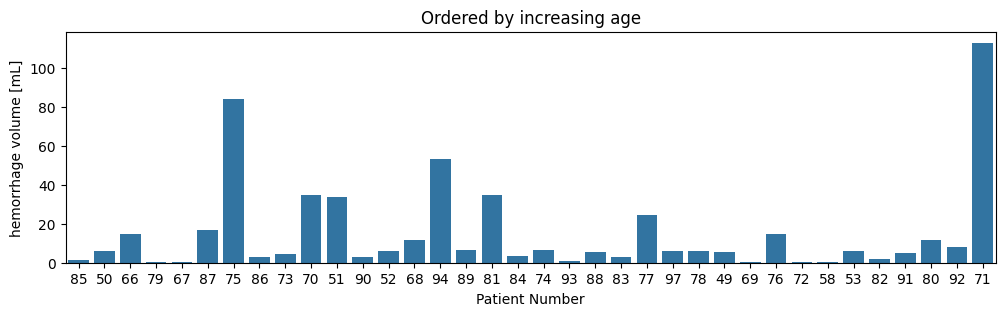

In [29]:
f, ax = plt.subplots(figsize=(12, 3))
sns.barplot(ax=ax, data=patients_df[patients_df['hemorrhage volume [mL]']>0], x='Patient Number', y='hemorrhage volume [mL]', order=patients_df[patients_df['hemorrhage volume [mL]']>0].sort_values(by='Age\n(years)').index)
ax.set_title('Ordered by increasing age')

### Look at the Largest Hemorrhages

Let's take a look at patient 71 and 75, they clearly have large hemorrhage volumes

Age\n(years)                                         72.0
Gender                                             Female
Intraventricular                                      NaN
Intraparenchymal                                      1.0
Subarachnoid                                          NaN
Epidural                                              NaN
Subdural                                              1.0
Fracture (Yes/No)                                     NaN
Condition on file         Subdural HGE+ Intracranial HGE 
Note                                                  NaN
hemorrhage volume [mL]                         112.703333
Name: 71, dtype: object


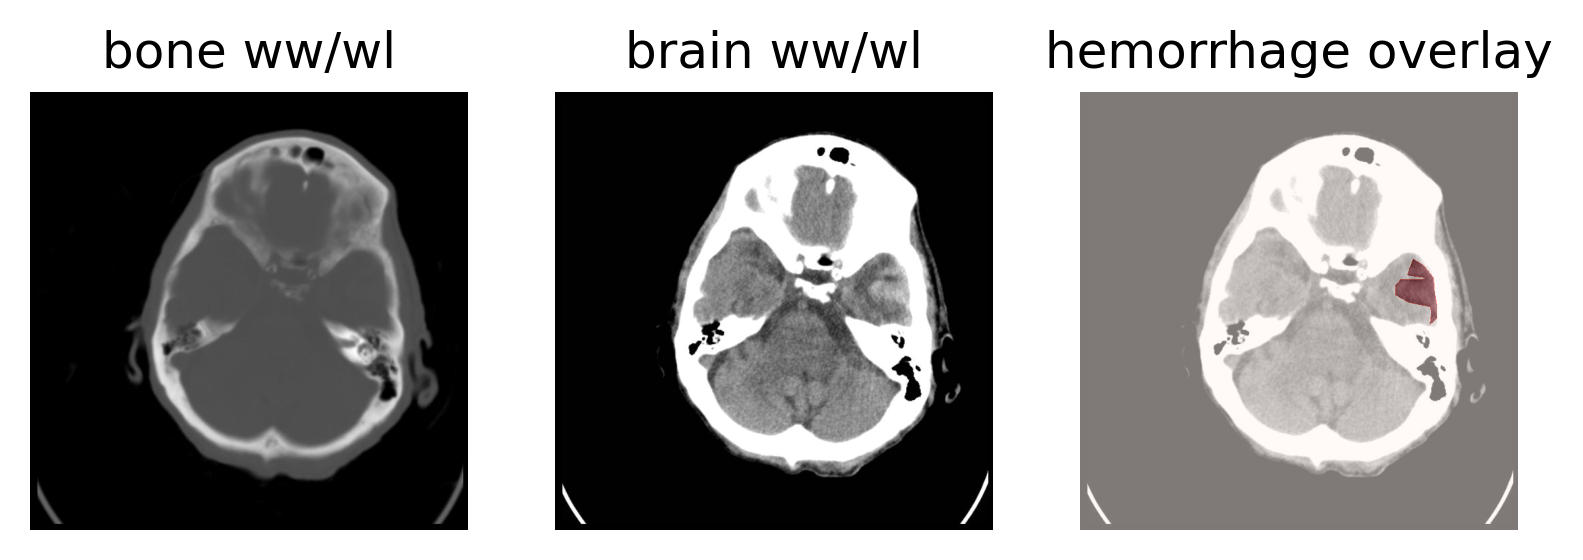

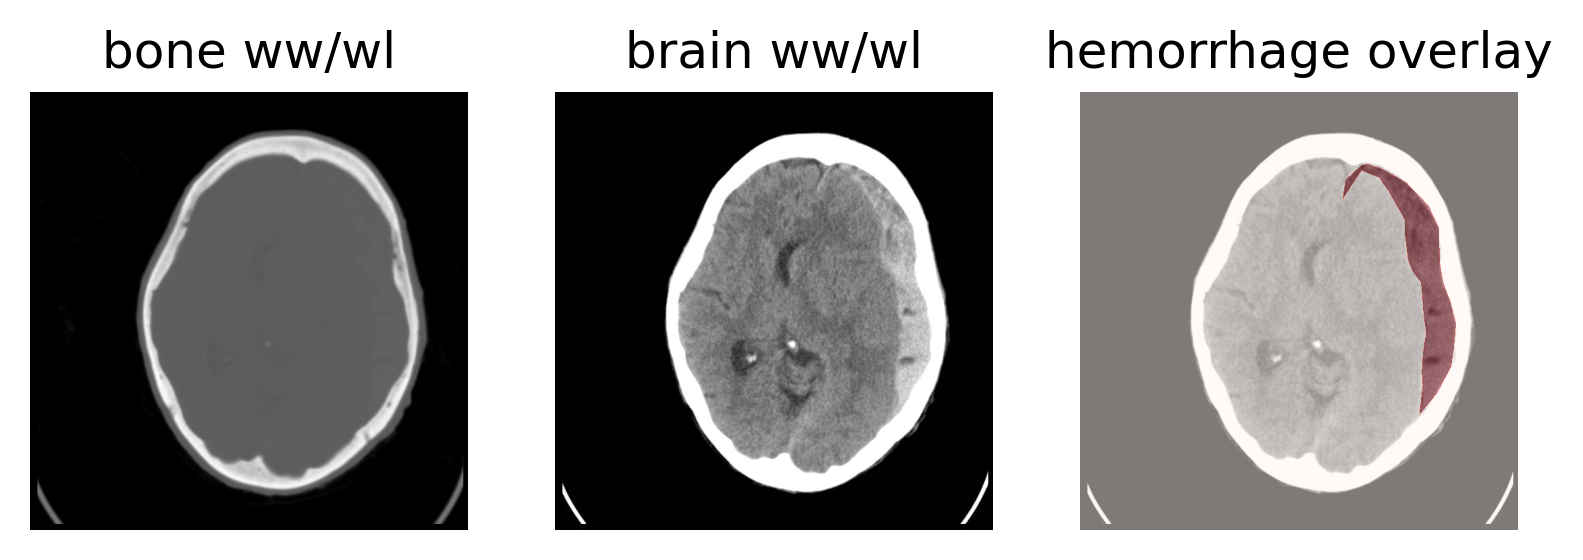

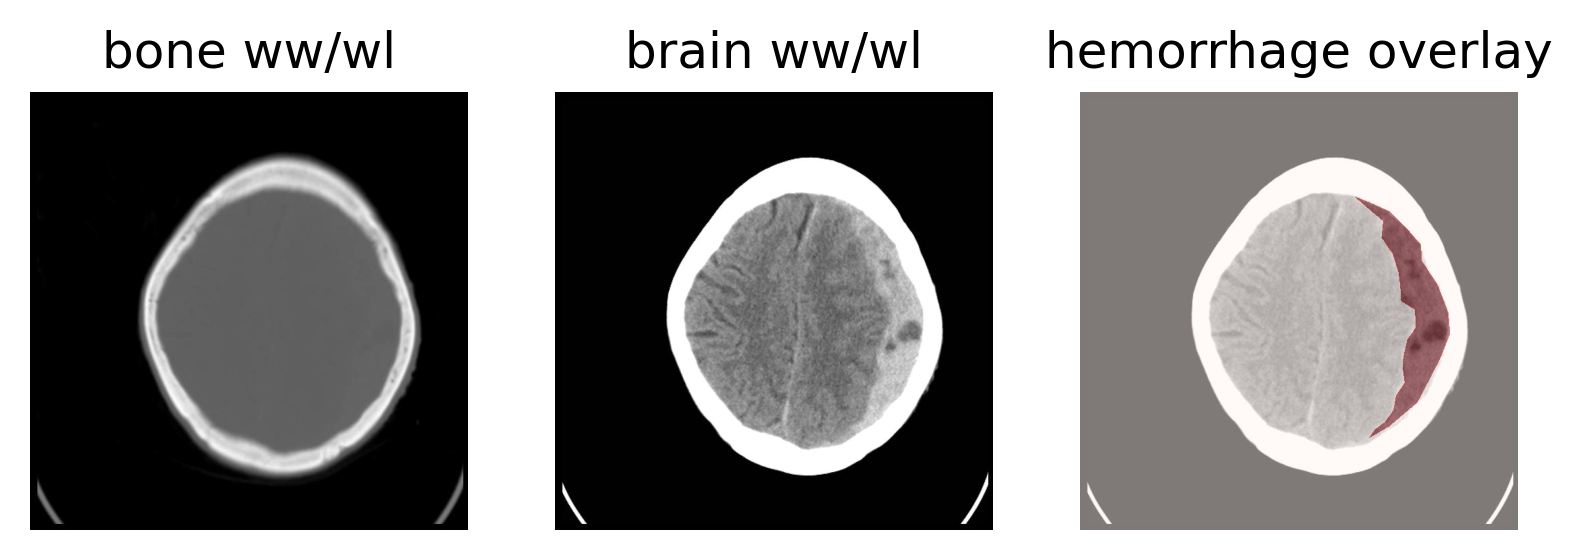

In [30]:
patient_id = 71
patient_71 = hemorrhages_df[(hemorrhages_df['PatientNumber']==patient_id)&(hemorrhages_df['No_Hemorrhage']==False)]
print(patients_df[patients_df.index==patient_id].iloc[0])
for i in np.linspace(0, len(patient_71), 3, dtype=int, endpoint=False):
    display_images(patient_71.iloc[i])

Note that in some of the hemorrhages above they are non-uniform - they have pockets of low attenuation inside the hemorrhage, this is discussed in [Hillal 2022](https://insightsimaging.springeropen.com/articles/10.1186/s13244-022-01309-1)

Age\n(years)                          3.0
Gender                               Male
Intraventricular                      NaN
Intraparenchymal                      NaN
Subarachnoid                          NaN
Epidural                              1.0
Subdural                              NaN
Fracture (Yes/No)                     NaN
Condition on file         Extradural HGE 
Note                                  NaN
hemorrhage volume [mL]          83.966801
Name: 75, dtype: object


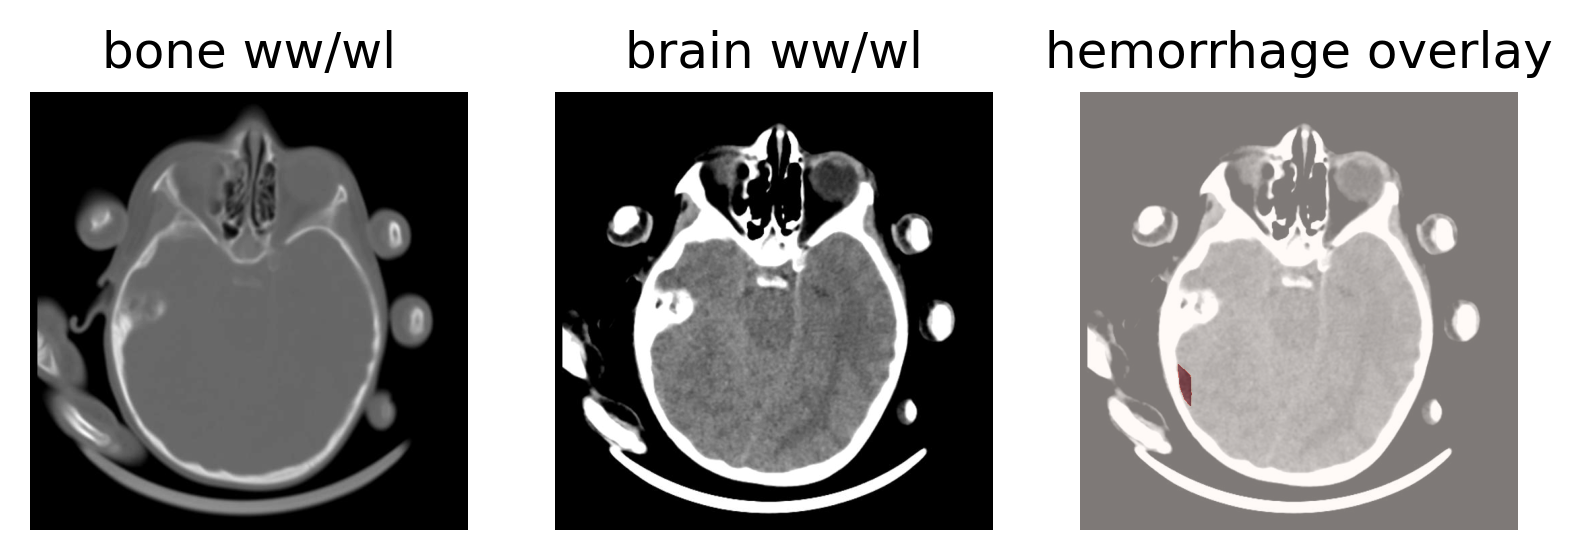

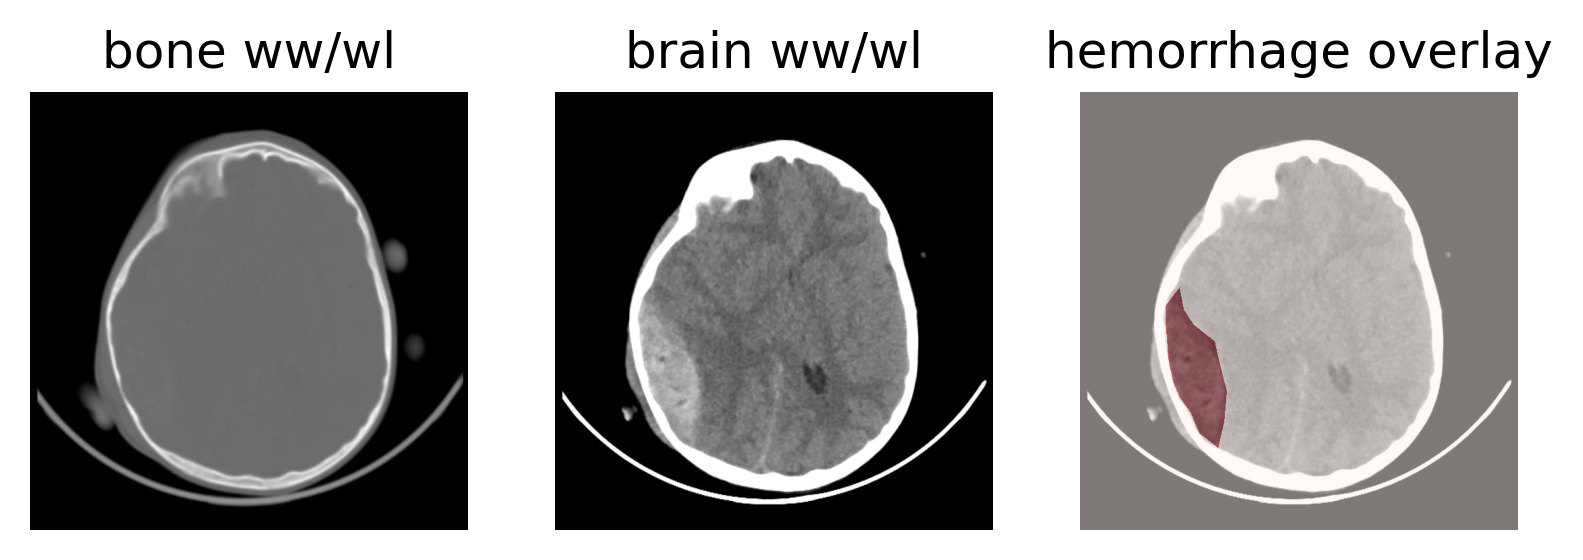

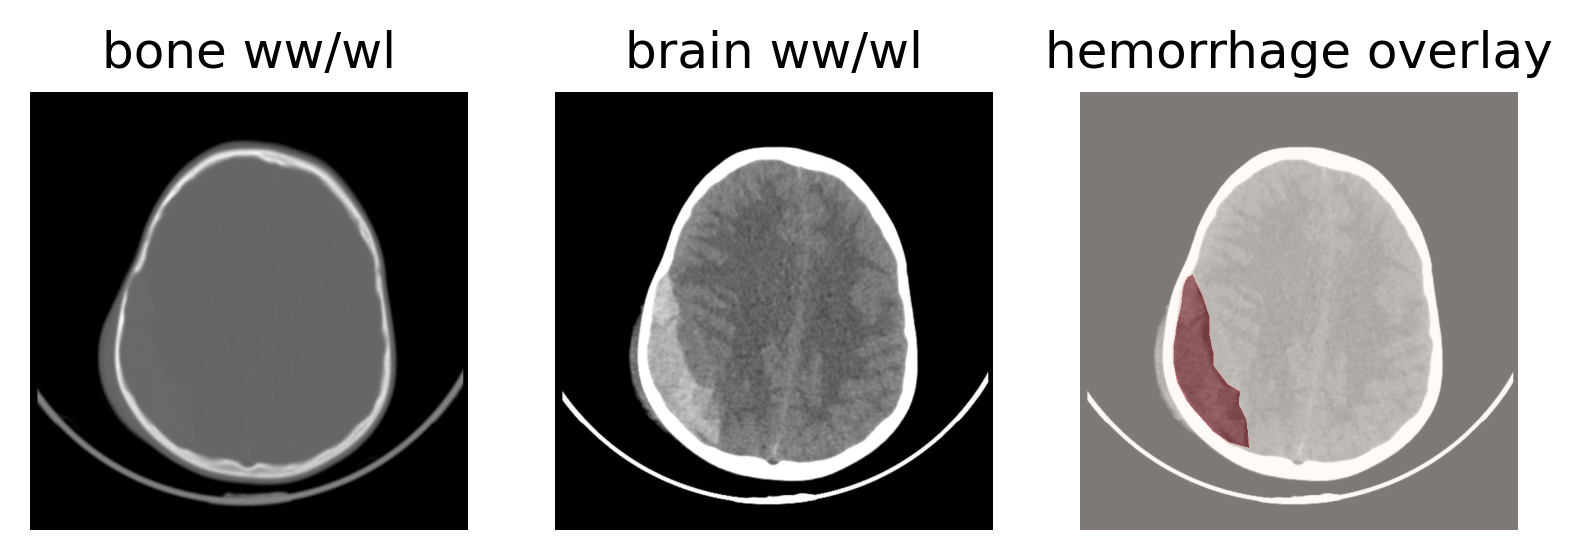

In [31]:
patient_id = 75
patient = hemorrhages_df[(hemorrhages_df['PatientNumber']==patient_id)&(hemorrhages_df['No_Hemorrhage']==False)]
print(patients_df[patients_df.index==patient_id].iloc[0])
for i in np.linspace(0, len(patient), 3, dtype=int, endpoint=False):
    display_images(patient.iloc[i])

Note this patient with the second largest hemorrhage volume is pediatric patient only 3 years old! This looks like a traumatic ICH given that there's blood on both sides of the skull.

**Anatomic differences**

These images convey some of the healthy anatomic differences that exist between adult and pediatric brain anatomy (described in more depth here [Figaji 2017](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5735372/)). Pediatric brains are generally 'too large' for the expanding skull resulting in thinner, often invisible to CT [sulci](https://en.wikipedia.org/wiki/Sulcus_(neuroanatomy)) (the grooves in the brain folds where cerebral spinal fluid pools around the brain), whereas in adults and older adults the brain "shrinks" create larger sulci that fill with darker, water-equivalent HU CSF as illustrated in this 72 year old adult brain image (patient 71) on the left and pediatric 3 year old on the right (patient 75).

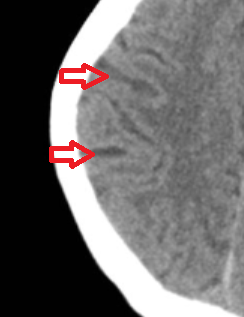
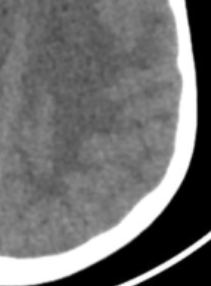

In [32]:
zero_hemorrhage_volume_patients = len(patients_df[patients_df['hemorrhage volume [mL]']<1])
nonzero_hemorrhage_volume_patients = len(patients_df[patients_df['hemorrhage volume [mL]']>0])
print(f'patients with no measured hemorrhage (volume = 0 mL): {nonzero_hemorrhage_volume_patients} / {len(patients_df)} total [{round(100*zero_hemorrhage_volume_patients/len(patients_df))} %]')
print(f'patients with measured hemorrhage (volume > 0 mL): {nonzero_hemorrhage_volume_patients} / {len(patients_df)} total [{round(100*nonzero_hemorrhage_volume_patients/len(patients_df))} %]')

patients with no measured hemorrhage (volume = 0 mL): 36 / 82 total [62 %]
patients with measured hemorrhage (volume > 0 mL): 36 / 82 total [44 %]


## Hemorrhage Density

Here's we'll be using both the mask and the images to look at the voxel intensity histograms inside the segmented hemorrhages...

Try to look into quantitative descriptors of heterogeneity to capture the irregular density such as [entropy](https://scikit-image.org/docs/stable/auto_examples/filters/plot_entropy.html)